In [6]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
pylab.rcParams.update(params)

In [ ]:
import pandas as pd 
import numpy as np 
import glob
import re

Well_Treatment_dic={'A3':'a','B3':'b','C3':'c','D3':'d'}
df = pd.DataFrame()

path='path_to_folder'   
cell_file_path=glob.glob(path+'/all_image*/*Cells.csv')

for i in cell_file_path:
    df_cell=pd.read_csv(i)
    df_cell['Well']=re.search('[A-Z]{1}[\d]{1}',i).group()
    df_cell['Treatment']=Well_Treatment_dic[re.search('[A-Z]{1}[\d]{1}',i).group()]
    df=pd.concat([df, df_cell], ignore_index=True)

pd.set_option('display.max_columns', None)
df


In [4]:
pd.set_option('display.max_rows', None)
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)
df.isnull().sum().sum()

0

In [ ]:
df.Treatment.value_counts().plot.bar()
plt.xticks(rotation=0)

In [6]:
df_twogroup=df.loc[df['Treatment'].isin(['a','b'])]
X = df_twogroup.drop(['Treatment'],axis = 1)
y = df_twogroup.Treatment
X_numerical = X.select_dtypes('number')
X_useful=X_numerical.loc[:,X_numerical.iloc[1:5,].nunique() > 1]
X_useful=X_useful.drop(['ObjectNumber','Number_Object_Number','Parent_PrefilterCellsed'],axis=1,errors='ignore')
df_preprocessed=X_useful.join(y)
df_preprocessed.shape

(153093, 236)

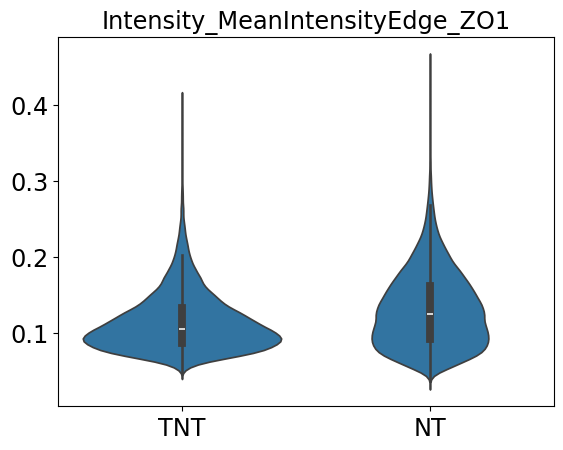

In [8]:
#plot violin plot for two groups for specific feature
import pandas as pd 
df=pd.read_feather('/sample.feather')


import seaborn as sns
df_twogroup=df.loc[df['Treatment'].isin(['a','b'])]
fig, axes = plt.subplots()
# plot violin. 'Scenario' is according to x axis, 
# 'LMP' is y axis, data is your dataframe. ax - is axes instance

sns.violinplot(x='Treatment',y='feature_name', data=df_twogroup, ax = axes)

axes.set_xlabel('')
axes.set_ylabel('')
axes.set_title('Intensity_MeanIntensityEdge_ZO1')
#axes.set_ylim(0,2)

plt.show()

In [10]:
#statistical test 
from scipy import stats
feature_name='feature-3'
print(stats.ttest_ind(df[df['Treatment']=='a'][feature_name], df[df['Treatment']=='b'][feature_name]))
print(stats.kstest(df[df['Treatment']=='a'][feature_name], df[df['Treatment']=='b'][feature_name]))
print(stats.ranksums(df[df['Treatment']=='a'][feature_name], df[df['Treatment']=='b'][feature_name]))

TtestResult(statistic=-46.44351928922134, pvalue=0.0, df=186955.0)
KstestResult(statistic=0.11928742820877031, pvalue=0.0, statistic_location=0.1035232178241334, statistic_sign=1)
RanksumsResult(statistic=-50.78816781677428, pvalue=0.0)


logistic regression test accuracy: 0.955 
logistic regression train accuracy: 0.973125 


<Figure size 600x600 with 0 Axes>

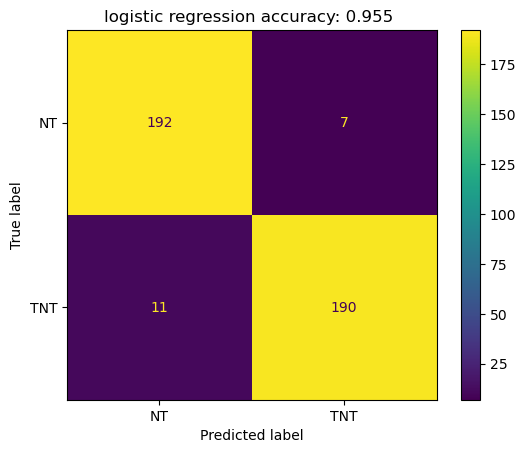

In [3]:
from matplotlib.backends.backend_pdf import PdfPages
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt
df_twogroup=df.loc[df['Treatment'].isin(['a','b'])]
X = df_twogroup.drop(['Treatment'],axis = 1)
y = df_twogroup.Treatment
X_numerical = X.select_dtypes('number')
X_useful=X_numerical.loc[:,X_numerical.iloc[1:5,].nunique() > 1]
X_useful=X_useful.drop(['ObjectNumber','Number_Object_Number','Parent_PrefilterCellsed','Parent_Cells'],axis=1,errors='ignore')
df_preprocessed=X_useful.join(y)
#df_sample=df_preprocessed.groupby("Treatment").sample(n=min(df_preprocessed.Treatment.value_counts()), random_state=1)
df_sample=df_preprocessed.groupby("Treatment").sample(n=1000, random_state=1)
X_useful = df_sample.drop(['Treatment'],axis = 1)
y_sample = df_sample.Treatment
x_train, x_test, y_train, y_test = train_test_split(X_useful, 
                                                    y_sample, 
                                                    test_size=0.2, 
                                                    random_state=42)
scaler = StandardScaler()
normalized_x_train = pd.DataFrame(
    scaler.fit_transform(x_train),
    columns = x_train.columns
)
normalized_x_test = pd.DataFrame(
    scaler.transform(x_test),
    columns = x_test.columns
)

#logistic regression for two groups
logreg = LogisticRegression(max_iter=5000)
logreg.fit(normalized_x_train, y_train)
y_pred = logreg.predict(normalized_x_test)
print('logistic regression test accuracy: {} '.format(accuracy_score(y_test, y_pred)))
print('logistic regression train accuracy: {} '.format(accuracy_score(y_train, logreg.predict(normalized_x_train))))
conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,6))
disp=ConfusionMatrixDisplay(conf_mat,display_labels=logreg.classes_)
disp.plot()
plt.title('logistic regression accuracy: {} '.format(accuracy_score(y_test, y_pred)))
plt.show()